[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset Head:
   label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Dataset Info:
 None

Label Distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


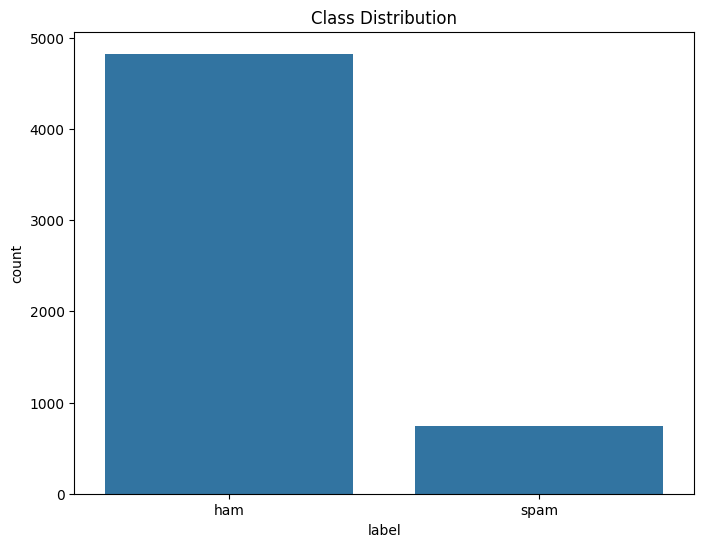


Message Length Statistics:
        length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0


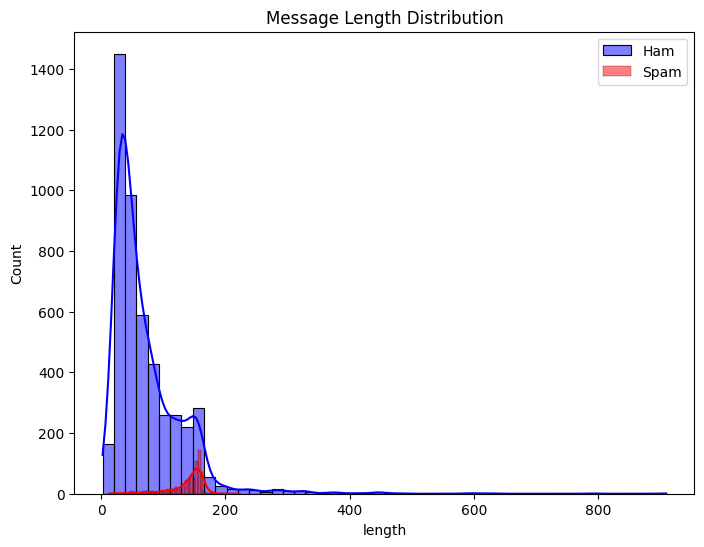

Best Naive Bayes parameters: {'alpha': 0.5}

Naive Bayes Performance (with Grid Search CV)
Accuracy: 0.9739910313901345
Confusion Matrix:
 [[962   4]
 [ 25 124]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       0.97      0.83      0.90       149

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Best Logistic Regression parameters: {'C': 100}

Logistic Regression Performance (with Grid Search CV)
Accuracy: 0.9802690582959641
Confusion Matrix:
 [[961   5]
 [ 17 132]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg     

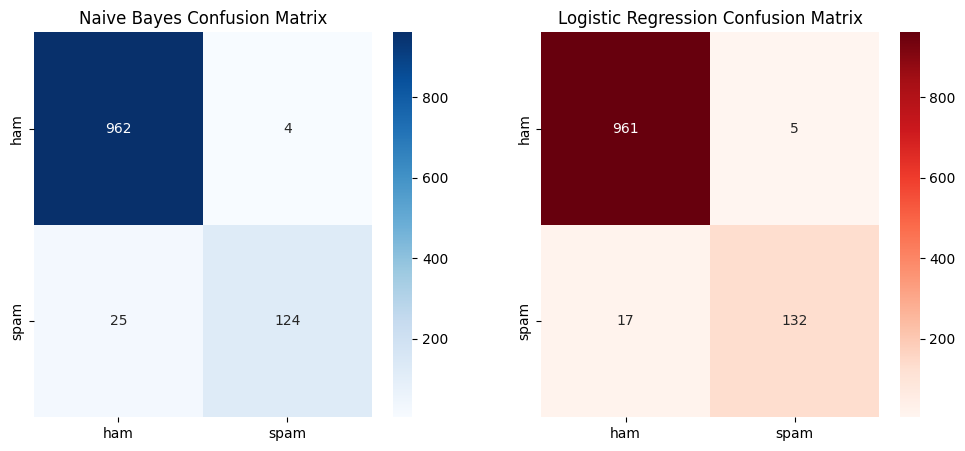


Some misclassified examples by Logistic Regression:
                                                 message label
5     FreeMsg Hey there darling it's been 3 week's n...  spam
670                               Did u receive my msg?   ham
3981                                 ringtoneking 84484  spam
2057  .Please charge my mobile when you get up in mo...   ham
3360  Sorry I missed your call let's talk when you h...  spam


In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("SMSSpamCollection", sep='\t', names=["label", "message"], header=None)

# Exploratory Data Analysis (EDA)
print("Dataset Head:\n", df.head())
print("\nDataset Info:\n", df.info())
print("\nLabel Distribution:\n", df['label'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

# Analyze message length
df['length'] = df['message'].apply(len)
print("\nMessage Length Statistics:\n", df[['label', 'length']].groupby('label').describe())

# Visualize message length distribution
plt.figure(figsize=(8, 6))
sns.histplot(df[df['label'] == 'ham']['length'], bins=50, color='blue', label='Ham', kde=True)
sns.histplot(df[df['label'] == 'spam']['length'], bins=50, color='red', label='Spam', kde=True)
plt.title('Message Length Distribution')
plt.legend()
plt.show()

# Text Cleaning Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned'] = df['message'].apply(clean_text)

# Feature Extraction using TF-IDF
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['cleaned'])
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define Stratified K-Fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Naive Bayes Model with Grid Search ---
nb = MultinomialNB()
param_grid_nb = {'alpha': [0.5, 1.0, 1.5, 2.0]}  # Smoothing parameter
grid_nb = GridSearchCV(nb, param_grid_nb, cv=skf, scoring='accuracy')
grid_nb.fit(X_train, y_train)
best_nb = grid_nb.best_estimator_
print("Best Naive Bayes parameters:", grid_nb.best_params_)

# Evaluate Naive Bayes on the test set
y_pred_nb = best_nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
cm_nb = confusion_matrix(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb, target_names=['ham', 'spam'])
print("\nNaive Bayes Performance (with Grid Search CV)")
print("Accuracy:", acc_nb)
print("Confusion Matrix:\n", cm_nb)
print("Classification Report:\n", report_nb)

# --- Logistic Regression Model with Grid Search ---
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization strength
grid_lr = GridSearchCV(lr, param_grid_lr, cv=skf, scoring='accuracy')
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
print("Best Logistic Regression parameters:", grid_lr.best_params_)

# Evaluate Logistic Regression on the test set
y_pred_lr = best_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr, target_names=['ham', 'spam'])
print("\nLogistic Regression Performance (with Grid Search CV)")
print("Accuracy:", acc_lr)
print("Confusion Matrix:\n", cm_lr)
print("Classification Report:\n", report_lr)

# Visualize Confusion Matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Naive Bayes Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Reds', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Logistic Regression Confusion Matrix')

plt.show()

# Error Analysis: Display some misclassified examples from Logistic Regression
misclassified_indices = y_test[y_test != y_pred_lr].index
misclassified_examples = df.loc[misclassified_indices, ['message', 'label']]
print("\nSome misclassified examples by Logistic Regression:\n", misclassified_examples.head())
